## I. Preamble

In [65]:
pip install serial

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
from datetime import datetime
from dataclasses import dataclass, asdict
import time
import numpy as np
import serial

In [ ]:
import sys
sys.path.append(r"E:\00 Script\Attodry800.Characterization\src")
import Atto800
import calibration

In [ ]:
sys.path.append(r"E:\00 Script\Laborinstrumente\src")
import Keithley2400

### Select Instruments

In [1]:
AttoDry800=True
Keithley2400=True
AttoDrySteps=True
LakeShoreMonitor=False


#### Attocube

In [2]:
IP = "192.168.1.1"
Atto=Atto800.Device(IP)

NameError: name 'Atto800' is not defined

In [3]:
Atto.connect()

#### Keithley

In [6]:
COM_PORT = 'COM5'   
GPIB_ADDR = 5

In [7]:
keithley = Keithley2400.Device(COM_PORT, GPIB_ADDR)
print("Connected to:", keithley.idn())

SerialException: could not open port 'COM5': FileNotFoundError(2, 'Das System kann die angegebene Datei nicht finden.', None, 2)

## II. Set Parameters

### Attocube

In [3]:
TestMode         = 2 # 1 Erwärmung 2 Abkühlung 
ControlMode      = 2 # 1 Sample-Plate Control 2 Sample-Plate and Cold-Plate Temperature Control
TimeControlMode      = 1 # 1 Timestep includes the time needed for reaching a temperature 2 TimeStep aften reaching temperature
Temperaturen     = [5,8,9,10,20,30,40,50,60,70,80,90,100,150,200,250,275,295,300] # Test Temperaturen, the min Temperature must be possible
TimeStep         = 3*60  # [s]

In [ ]:
AttoSteps(TestMode,ControlMode,Temperaturen,TimeSteps)

### Keithley

In [4]:
VoltageRange= [(100,1),
              (400,2)] # (Temperature in  K, Voltage Range in V)
CurrentRange =1E-3    # 1E-3 = 1 mA
VoltageCompliance= 1  # Maximum Voltage

Strom                 = [0, 0.1e-3,0.2e-3] # Set currents fot the measurement
TimeMeasurement      = 30 # Duration of the current and measurement
TimeSleepCurrent     = 60 # Waiting time to set each current [s]
SampleRate           = 1 # number of seconds per measurement [s]

### Filename and Confirmation

In [ ]:
Name      ="Muster" # Short name
LogName         = f"{Name}.txt"
Designation     = f"{Name}.csv"

In [ ]:
filename         = calibration.setFilename(Designation)
TargetTemp       = calibration.setT_target(TestMode,Temperaturen)
MeasurementPoints= calibration.getMeasurementpoints(TimeMeasurement,SampleRate)

In [7]:
Parameters = calibration.TestParameters(Designation, 
                 TestMode,
                 ControlMode,
                TargetTemp,
                TimeStep,
                VoltageRange,
                CurrentRange,
                VoltageCompliance,
                Strom,
                TimeMeasurement,
                TimeSleepCurrent,
                SampleRate,
                MeasurementPoints,
                filename)

In [8]:
calibration.bestätigung(Parameters)

The estimated time to complete the test is min 2.375 hours (Time for reaching the target temperature not considered)
The measurement will be carried out during the cooling down
The following temperatures will be set (in this order) [300, 295, 275, 250, 200, 150, 100, 90, 80, 70, 60, 50, 40, 30, 20, 10, 9, 8, 5]
Both temperature of the sample plate and cold plate will be controlled. If the mode is heating up, the cold plate has to be cooled down again until 4 K after the measurement is completed.


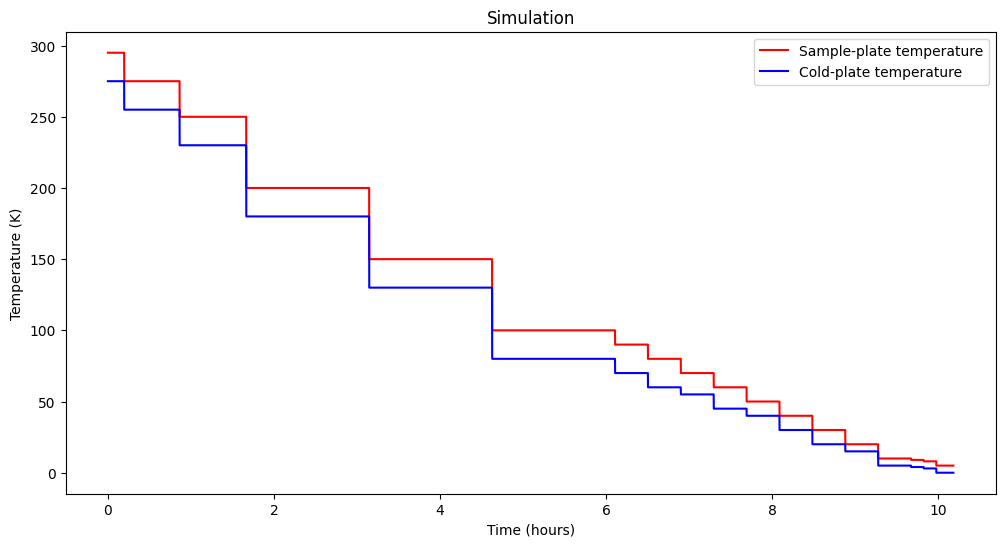

In [9]:
calibration.plotSimulation(Parameters)

## III. Functions

In [10]:
def defineVoltageRange(T,VoltageRange):
    triggered=0
    for i in VoltageRange:
        
        if T <=i[0] and triggered ==0:
            Range=i[1]
            triggered=i[1]
    return Range
            
    

In [11]:
defineVoltageRange(300,VoltageRange)

2

In [12]:
def saveLog(Name,Parameters):
    with open(Name, "w") as f:
        for key, value in asdict(Parameters).items():
            f.write(f"{key}: {value}\n")

In [13]:
saveLog(LogName,Parameters)

In [14]:
#keithley.enable_4wire()
#keithley.source_CurrentMode()
#keithley.set_CurrentRange(1E-3) # 1E-3 = 1 mA
#keithley.set_current(0.1e-3)    # 0.1e-3 = 0.1m A
#keithley.set_VoltageCompliance(1) # 1V
#keithley.set_VoltageSense()
#keithley.set_VoltageRange(1) # 1V
#keithley.output_on()  # The instrument will only start when the above parameters are defined.
#keithley.output_off() # Stop the current generation

In [15]:
def initKeithley(Parameters):
    keithley.enable_4wire()
    keithley.source_CurrentMode()
    keithley.set_CurrentRange(Parameters.CurrentRange)
    keithley.set_VoltageCompliance(Parameters.VoltageCompliance)
    keithley.set_VoltageSense()
    

In [16]:
def getMeasurement(T_set, Parameters, strom):
    """Get the measurement in Table form at the instant"""
    n_points=Parameters.MeasurementPoints
    sample_rate=Parameters.SampleRate
    
    data_total = []
    #initKeithley(Parameters)
    #keithley.set_VoltageRange(defineVoltageRange(T_set))
    #keithley.output_on()
    
    for i in n_points:
        TS = Atto.sample.getTemperature()
        TC = Atto.tboard.getTemperature(0)
        Q = Atto.sample.getHeaterPower()
        R_sensor = Atto.sample.getResistance()

        #keithley.set_current(strom)
        #Sourcemeter = keithley.get_Mess()
        #V, I, R_sample = getVoltageCurrentResistance(Sourcemeter)
        V=0
        I=0
        R_sample=0

        data = {
            'Time[s]': datetime.now().timestamp(),
            'Cold-Plate[K]': TC,
            'Sensor Resistance[Ohm]': R_sensor,
            'Sample Temperature[K]': TS,
            'Sample Heat[W]': Q,
            'Set Temperature[K]': T_set,
            'Voltage [V]': V,
            'Set Current [I]': strom,
            'Current [I]': I,
            'Sample Resistance [Ohm]': R_sample
        }

        time.sleep(sample_rate)
        data_total.append(data)
    #keithley.output_off()
    return data_total

In [17]:
def firstMeasurement(getMeasurement,Parameters):
    """Get the first measurement"""

    data_total = []
    #initKeithley(Parameters)
    TS = Atto.sample.getTemperature()
    #keithley.set_VoltageRange(defineVoltageRange(TS))
    #keithley.output_on()
    
    for strom_target in Parameters.Strom:
        log = getMeasurement(TS, Parameters,strom_target)  # Get the measurement
        log_total.extend(log)
        time.sleep(Parameters.TimeSleepCurrent)
        print(log)
                
        
    df_logtotal = pd.DataFrame(log_total)
    df_logtotal.to_csv(Parameters.filename, index=False)
    #keithley.output_off()
    return df_logtotal
    

In [18]:
def getcoolingrate(t):
    """Compute the cooling rate in a  determined delta time t"""
    TS1=Atto.sample.getTemperature()
    time.sleep(t)
    TS2=Atto.sample.getTemperature()

    dTds=(TS2-TS1)/t

    
    return dTds

In [19]:
def getcoolingrateExchange(t):
    """Compute the cooling rate in a  determined delta time t"""
    TS1=Atto.exchange.getTemperature()
    time.sleep(t)
    TS2=Atto.exchange.getTemperature()

    dTds=(TS2-TS1)/t

    
    return dTds

In [20]:
def perform_approach(mode_test, mode_control, T_target):
    """Perform an approach to the set temperature value. The transition should be smooth close to the set temperature value"""

    t_limitColdPlate=1*3600
    t_limitSamplePlate=1.5*3600
    dTds = getcoolingrateExchange(1) #Time step 1s
    T_targetSample=T_target
    T_target=T_target-computeColdplateTemperature(T_target)
    Ts = Atto.exchange.getTemperature()
    Delta = T_target- Ts

    print("performing an approach")
    print("Target value in Coldplate",T_target)

    count=0
    n_dTds=0
    if mode_test == 1: ## Erwärmung
        while n_dTds <10:  # with 0.001 it got stuck.  It was a case with 7.998 which was higher than 0.001 delta. That means, T set remained as  +dTds*-5
            T_set = T_target
            
            print(T_set)
            startControl(T_set, T_target, mode_control)
            

            dTds = getcoolingrate(2)
           
            Ts = Atto.sample.getTemperature()
           
            Delta = T_target - Ts
            if abs(dTds) <= 0.0001:
                n_dTds=n_dTds+1
            
    elif mode_test == 2: ## Abkühlung

        while  n_dTds <5 and count<=t_limitColdPlate:  
            # if -Delta>10:
            #   T_set=T_target
            #if 5<-Delta <= 10:

             #   T_set = T_target + dTds * -300
            if 1<-Delta <= 10:
                T_set = T_target + dTds * -30

            elif 0.01<-Delta <= 1:
                T_set = T_target + dTds * -20
                
            elif -Delta <= 0.01:
                T_set = T_target + dTds * -10
            else:
                T_set=T_target
            
            print("T_set value",T_set)
            print("Coolingrage",dTds)
           
            startControlExchange(T_set)
            startControl(T_targetSample, T_targetSample, mode_control)
            if abs(dTds) <= 0.01:
                n_dTds=n_dTds+1
              
            
            dTds = getcoolingrateExchange(2)
            Ts = Atto.exchange.getTemperature()
            Delta = T_target - Ts
            count=count+1
        startControlExchange(T_target)
        
        print("approach finished Cold Plate")
        n_dTds=0
        
        while n_dTds <10 and count<=t_limitSamplePlate:  
            
            T_set = T_target
            
            startControl(T_targetSample, T_targetSample, mode_control)
            
            dTds_Sample = getcoolingrate(2)
           
            if abs(dTds_Sample) <= 0.005:
                n_dTds=n_dTds+1
            count=count+1
            
        print("approach finished")
    return

In [21]:
def perform_approachSample(mode_test, mode_control, T_target):
    """Perform an approach to the set temperature value. The transition should be smooth close to the set temperature value"""
    # startControl(T_target, mode_control)
    dTds = getcoolingrate(1) #Time step 1s
    Ts = Atto.sample.getTemperature()
    Delta = T_target - Ts

    print("performing an approach")
    n_dTds=0
    if mode_test == 1: ## Erwärmung
        while n_dTds <10:  # with 0.001 it got stuck.  It was a case with 7.998 which was higher than 0.001 delta. That means, T set remained as  +dTds*-5
            T_set = T_target
            
            print(T_set)
            startControl(T_set, T_target, mode_control)

            dTds = getcoolingrate(2)
            Ts = Atto.sample.getTemperature()
            Delta = T_target - Ts
            if abs(dTds) <= 0.0001:
                n_dTds=n_dTds+1
            
    elif mode_test == 2: ## Abkühlung

        while  n_dTds <10:  # with 0.001 it got stuck.  It was a case with 7.998 which was higher than 0.001 delta. That means, T set remained as  +dTds*-5
            # if -Delta>10:
            #   T_set=T_target
            #if 5<-Delta <= 10:

                #T_set = T_target + dTds * -300
            if 1<-Delta <= 5:
                T_set = T_target + dTds * -200

            elif 0.01<-Delta <= 1:
                T_set = T_target + dTds * -50
                
            elif -Delta <= 0.01:
                T_set = T_target + dTds * -30
            else:
                T_set=T_target
            #print(-Delta)
            print(T_set)
            print(dTds)
            startControl(T_set, T_target, mode_control)
            if abs(dTds) <= 0.0001:
                n_dTds=n_dTds+1
                
            dTds = getcoolingrate(2)
            
            #time.sleep(1)
            #dTds = getcoolingrate(1)
            Ts = Atto.sample.getTemperature()
            Delta = T_target - Ts
        startControl(T_target, T_target, mode_control)
    print("approach finished")
    return

In [22]:
def startTest(getMeasurement,Parameters):
    """Start the test"""
    log_total = []
    #log_total = firstMeasurement(getMeasurement,Parameters)
    triggered = set()

    ## Calibration

    # while True:
    TS = Atto.sample.getTemperature()

    for i in Parameters.TargetTemperaturen:

        if Parameters.TestMode==1:
            condition=TS <= i
        else:
            condition=TS >= i
            
        if condition and i not in triggered:
            print(f"\n==> T close to Target {i} K found. Starting control.")
            triggered.add(i)

            perform_approach(Parameters.TestMode, Parameters.ControlMode, i)

            # startControl(i, mode_control)
            # t_sleep=getsleeptime(i)

            time.sleep(Parameters.TimeStep)  # Waiting time for starting the measurement after the settling time
            for strom_target in Parameters.Strom:
                log = getMeasurement(i, Parameters,strom_target)  # Get the measurement
                log_total.extend(log)
                time.sleep(Parameters.TimeSleepCurrent)
                print(log)

        TS = Atto.sample.getTemperature()
        if Parameters.TestMode == 2:
            stopControl(Parameters.ControlMode)

        # df_logtotal=pd.DataFrame(log_total)
        # df_logtotal.to_csv(filename, index=False)
    # print(log_total)
    df_logtotal = pd.DataFrame(log_total)
    df_logtotal.to_csv(Parameters.Filename, index=False)

    # time.sleep(5) # Compare each 5s

    #   if len(triggered) == len(T_target):
    #      print("All temperature controls completed.")
    #     break

    print(log_total)

    Atto.sample.stopTempControl()
    Atto.exchange.stopTempControl()
    #keithley.output_off()

In [23]:
def stopControl(mode_Control):
    """Stop the temperature control"""
    Atto.sample.stopTempControl()
    if mode_Control==2:
        Atto.exchange.stopTempControl()

In [24]:
def startControlExchange(Temperature):
    """Start the temperature control"""
    
    Atto.exchange.setSetPoint(Temperature)  # Previously coldplate directly -20 wrt the set temperature. this created an oscillation on the sample temperature value after 10min
    Atto.exchange.startTempControl()

In [25]:
def startControl(Temperature, T_target, mode_control):
    """Start the temperature control"""
    
    Atto.sample.startTempControl()
    Atto.sample.setSetPoint(Temperature)
    if mode_control == 2:
        Atto.exchange.setSetPoint(Temperature - computeColdplateTemperature( Temperature))  # Previously coldplate directly -20 wrt the set temperature. this created an oscillation on the sample temperature value after 10min
        Atto.exchange.startTempControl()

In [26]:
def computeColdplateTemperature(T):
    """Set the minimum delta required between the sample and coldplate based september 25 measurement"""
    ## von Oyuka bis 250917 Heizung 1
    if 75 < T <= 300:
        delta = 10
    elif 50 < T <= 75:
        delta = 15
    elif 25 < T <= 50:
        delta = 10
    elif T <= 25:
        delta = 5

    return delta

In [27]:
def computeColdplateTemperatureOriginal(T):
    """Set the minimum delta required between the sample and coldplate based september 25 measurement"""
    ## von Oyuka bis 250917 Heizung 1
    if 75 < T <= 300:
        delta = 20
    elif 50 < T <= 75:
        delta = 15
    elif 25 < T <= 50:
        delta = 10
    elif T <= 25:
        delta = 5

    return delta

## IV. Measurement

In [28]:
Parameters

TestParameters(name='Muster.csv', TestMode=2, ControlMode=2, TargetTemperaturen=[300, 295, 275, 250, 200, 150, 100, 90, 80, 70, 60, 50, 40, 30, 20, 10, 9, 8, 5], TimeStep=180, VoltageRange=[(100, 1), (400, 2)], CurrentRange=0.001, VoltageCompliance=1, Strom=[0, 0.0001, 0.0002], TimeMeasurement=30, TimeSleepCurrent=60, SampleRate=1, MeasurementPoints=array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30.]), Filename='2025101714_Muster.csv')

In [ ]:
startTest(getMeasurement,Parameters)


==> T close to Target 250 K found. Starting control.
performing an approach
Target value in Coldplate 240
T_set value 240
Coolingrage -0.01799999999997226
T_set value 240
Coolingrage -0.02049999999999841
T_set value 240
Coolingrage -0.02400000000000091
T_set value 240
Coolingrage -0.02749999999997499
T_set value 240
Coolingrage -0.02950000000001296
T_set value 240
Coolingrage -0.02949999999998454
T_set value 240
Coolingrage -0.030000000000001137
T_set value 240
Coolingrage -0.03100000000000591
T_set value 240
Coolingrage -0.03100000000000591
T_set value 240
Coolingrage -0.03550000000001319
T_set value 240
Coolingrage -0.03149999999999409
T_set value 240
Coolingrage -0.03499999999999659
T_set value 240
Coolingrage -0.030499999999989313
T_set value 240
Coolingrage -0.03499999999999659
T_set value 240
Coolingrage -0.03550000000001319
T_set value 240
Coolingrage -0.03100000000000591
T_set value 240
Coolingrage -0.030000000000001137
T_set value 240
Coolingrage -0.03499999999999659
T_set va

In [4]:
Atto.exchange.stopTempControl()